<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) | [Contents](Index.ipynb) |

# Joint reactions

$$\text{shear:compression} = \frac{\sqrt{x^2 + y^2}}{|z|}$$

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim")
conf = Conf(project_path=project_path)
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
def parse_conditions(d):
    return (
        d.assign(
            mass=lambda x: x["filename"]
            .str.contains("r08")
            .replace({True: 8, False: 12})
        )
        .merge(
            pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
                columns={"group": "men"}
            ),
            on="participant",
            how="left",
        )
        .assign(height=1)
    )

In [5]:
suffix = "_JointReaction_ReactionLoads"
threshold = 0.56  # dislocation ratio (Dickerson et al.)


d = (
    pd.concat(
        [
            Analogs3d.from_sto(
                ifile, na_values=["             nan", "            -nan"]
            )
            .time_normalization()
            .to_dataframe()
            .assign(
                participant=ifile.parts[-3],
                filename=lambda x: ifile.stem + ifile.parts[-3] + f"{i}",
            )
            .reset_index()
            for i, ifile in enumerate(
                conf.project_path.glob(f"*/5_joint_reaction_force/*{suffix}*")
            )
        ]
    )
    .pipe(parse_conditions)
    .eval(
        "sc_ratio = sqrt(GHJ_on_humerus_in_glenoid_fx ** 2 + GHJ_on_humerus_in_glenoid_fy ** 2) / GHJ_on_humerus_in_glenoid_fz.abs()"
    )
    .assign(
        index=lambda x: x["index"] / 100, ratio_sup=lambda x: x["sc_ratio"] > threshold
    )
)

d = d.drop(d.filter(like="GH", axis=1), axis=1)
d.head()

,index,participant,filename,mass,men,height,sc_ratio,ratio_sup
0,0.00,antc,wu_expertsnovicesG_1_r08_4_JointReaction_React...,8,0,1,0.307743,False
1,0.01,antc,wu_expertsnovicesG_1_r08_4_JointReaction_React...,8,0,1,0.418359,False
2,0.02,antc,wu_expertsnovicesG_1_r08_4_JointReaction_React...,8,0,1,0.466880,False
3,0.03,antc,wu_expertsnovicesG_1_r08_4_JointReaction_React...,8,0,1,0.460193,False
4,0.04,antc,wu_expertsnovicesG_1_r08_4_JointReaction_React...,8,0,1,0.356652,False


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [6]:
d.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8       76
     12      84
1    8       50
     12      39
dtype: int64

In [7]:
balanced_trials = random_balanced_design(d, ["men", "mass"], random_state=RANDOM_SEED)[
    "filename"
].to_list()

In [8]:
d = d.query("filename == @balanced_trials")
d.drop_duplicates(["filename"]).groupby(["men", "mass"]).size()

men  mass
0    8       39
     12      39
1    8       39
     12      39
dtype: int64

## Time above dislocation ratio

In [9]:
sup_ratio = (
    d.groupby(["filename", "men", "mass"])["ratio_sup"]
    .apply(lambda x: x.sum() / x.shape[0])
    .reset_index()
)

sup_ratio.sample(5)

,filename,men,mass,ratio_sup
96,wu_expertsnovicesD_1_r12_4_JointReaction_React...,1,12,0.000000
69,wu_expertsnovicesD_1_r12_1_JointReaction_React...,1,12,0.059406
82,wu_expertsnovicesD_1_r12_2_JointReaction_React...,1,12,0.495050
76,wu_expertsnovicesD_1_r12_1_JointReaction_React...,1,12,0.049505
114,wu_expertsnovicesD_1_r12_5_JointReaction_React...,0,12,0.039604


In [10]:
sup_ratio.shape

(156, 4)

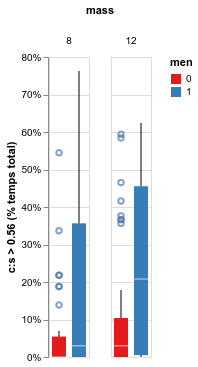

In [11]:
men_scale = alt.Scale(scheme="set1")
alt.Chart(sup_ratio).mark_boxplot().encode(
    alt.X("men:N", axis=alt.Axis(labels=False, ticks=False, domain=False), title=None),
    alt.Y("ratio_sup", axis=alt.Axis(format="%"), title="c:s > 0.56 (% temps total)"),
    alt.Color("men:N", scale=men_scale),
).facet(column="mass")

In [12]:
import spm1d

alpha = 0.05
n_iter = 10_000

spm = spm1d.stats.nonparam.anova2(
    y=sup_ratio["ratio_sup"], A=sup_ratio["men"], B=sup_ratio["mass"]
)
spmi = spm.inference(alpha=alpha, iterations=n_iter)
spmi

SnPM{F} inference list (0D)
   design      :  ANOVA2
   nEffects    :  3
   nPermUnique :  7.471e+275 permutations possible
   nPermActual :  10000
Effects:
   A     F = 14.825   p = <0.001
   B     F = 5.345    p = 0.021
   AB    F = 0.240    p = 0.626

In [13]:
for ispmi in spmi:
    if ispmi.h0reject:
        print(ispmi.effect)

Main A
Main B


In [14]:
def cohend(a, b):
    d = (a.mean() - b.mean()) / (np.sqrt((a.std() ** 2 + b.std() ** 2) / 2))
    if np.abs(d) >= 0.8:
        effect = "large"
    elif np.abs(d) >= 0.5:
        effect = "medium"
    elif np.abs(d) >= 0.2:
        effect = "small"
    else:
        effect = "no"
    return d, effect

In [20]:
a, b = [i.values for _, i in sup_ratio.groupby("mass")["ratio_sup"]]
print(a.mean() - b.mean())
cohend(a, b)

-0.0682914445290683


(-0.357737675438888, 'small')

In [18]:
sup_ratio.query("men == 0")["ratio_sup"].mean() - sup_ratio.query("men == 1")[
    "ratio_sup"
].mean()

-0.11373445036811371

<!--NAVIGATION-->
< [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) | [Contents](Index.ipynb) |